<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#LogisticRegression" data-toc-modified-id="LogisticRegression-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>LogisticRegression</a></span></li><li><span><a href="#DecisionTreeClassifier" data-toc-modified-id="DecisionTreeClassifier-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>DecisionTreeClassifier</a></span></li><li><span><a href="#Результаты-на-кросс-валидации-и-выбор-лучшей-модели" data-toc-modified-id="Результаты-на-кросс-валидации-и-выбор-лучшей-модели-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Результаты на кросс-валидации и выбор лучшей модели</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп» с BERT


# **Цель проекта**  
Интернет-магазин «Викишоп» запустил новый сервис, позволяющий пользователям редактировать описания товаров и комментировать правки. Однако возникает проблема — среди предложенных изменений могут встречаться токсичные комментарии.  

Цель проекта — **разработать модель машинного обучения, способную классифицировать комментарии на позитивные и негативные**, чтобы отправлять токсичные сообщения на модерацию. Необходимо достичь значения метрики *F1* не менее **0.75**.  

# **Описание данных**  
В нашем распоряжении набор данных `toxic_comments.csv`, который содержит:  
- **text** — текст комментария, оставленного пользователем.  
- **toxic** — целевой признак (1 — комментарий токсичный, 0 — нейтральный).  

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели.
3. Сделайте выводы.

# Используемые библиотеки

In [1]:
!pip install -q catboost

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch

from tqdm import tqdm
from tqdm import notebook

from transformers import AutoTokenizer, AutoModel, BertModel

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import resample
from imblearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from imblearn.over_sampling import RandomOverSampler

from google.colab import userdata

userdata.get('HF_TOKEN')

torch.cuda.empty_cache()

In [3]:
def generate_embeddings(dataframe, column_name, batch_size=100):
    """
    Функция для генерации эмбеддингов для текстов в DataFrame с использованием модели BERT.

    :param dataframe: pandas DataFrame с колонкой, содержащей текстовые данные.
    :param column_name: имя столбца с текстовыми данными.
    :param batch_size: размер батча для обработки данных (по умолчанию 100).

    :return: NumPy массив с эмбеддингами.
    """
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    # Инициализация токенизатора и модели
    tokenizer = AutoTokenizer.from_pretrained("unitary/toxic-bert")
    model = AutoModel.from_pretrained("unitary/toxic-bert").to(device)

    # Токенизация текстовых данных
    texts = dataframe[column_name].dropna().tolist()  # Убираем пропущенные значения
    texts = [str(text) for text in texts]  # Преобразуем все в строки

    # Генерация токенов с использованием batch_encode_plus
    encoding = tokenizer.batch_encode_plus(
        texts,
        add_special_tokens=True,      # Добавить специальные токены
        padding=True,                 # Дополнить до одинаковой длины
        truncation=True,              # Обрезать длинные последовательности
        return_attention_mask=True,   # Вернуть маску внимания
        return_tensors='pt',         # Вернуть тензоры PyTorch
        max_length=128
    )

    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    # Генерация эмбеддингов партиями
    embeddings = []
    for i in tqdm(range(0, len(input_ids), batch_size)):
      batch_input_ids = input_ids[i:i+batch_size]
      batch_attention_mask = attention_mask[i:i+batch_size]

      with torch.no_grad():
          outputs = model(input_ids=batch_input_ids, attention_mask=batch_attention_mask)

      batch_embeddings = outputs[0][:, 0, :].cpu()  # Переносим на CPU
      embeddings.append(batch_embeddings)

      # Удаляем ненужные переменные
      del batch_input_ids, batch_attention_mask, outputs
      torch.cuda.empty_cache()

    # Объединяем эмбеддинги в один массив
    embeddings = torch.cat(embeddings, dim=0)

    return embeddings

<div class="alert alert-success">
<font size="5"><b>Комментарий ревьюера</b></font>



Успех 👍:



👍Здорово Что предусмотрено возможность использования GPU




In [4]:
RANDOM_STATE=43

## Подготовка

In [5]:
data = pd.read_csv('https://code.s3.yandex.net/datasets/toxic_comments.csv', index_col=0)

<div class="alert alert-warning">
<font size="5"><b>Комментарий ревьюера</b></font>

Совет:


Если не знаешь - чтобы не было столбца  `Unnamed: 0` при чтении файла можно так:


    pd.read_csv(..., index_col=0)

    
(`Unnamed: 0` появляется при не совсем корректном сохранении файла)    


Unnamed: 0 это "след" старых индексов. Если ты уберёшь первые 10 примеров и своего датасета, сохранишь его, а потом откроешь,  то появится столбец Unnamed: 0 начиная с цифры 9, и появится новый индексы начиная с нуля


Но это мелочь,  даже не нужно ничего исправлять. Просто знай, чтобы увидев такое в чужом коде не удивляться что бы это могло означать

In [6]:
data.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [7]:
data.tail()

,text,toxic
159446,""":::::And for the second time of asking, when ...",0
159447,You should be ashamed of yourself \n\nThat is ...,0
159448,"Spitzer \n\nUmm, theres no actual article for ...",0
159449,And it looks like it was actually you who put ...,0
159450,"""\nAnd ... I really don't think you understand...",0


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
,Index: 159292 entries, 0 to 159450
,Data columns (total 2 columns):
, #   Column  Non-Null Count   Dtype 
,---  ------  --------------   ----- 
, 0   text    159292 non-null  object
, 1   toxic   159292 non-null  int64 
,dtypes: int64(1), object(1)
,memory usage: 3.6+ MB


Посмотрим на распределение классов

Text(0.5, 0, '')

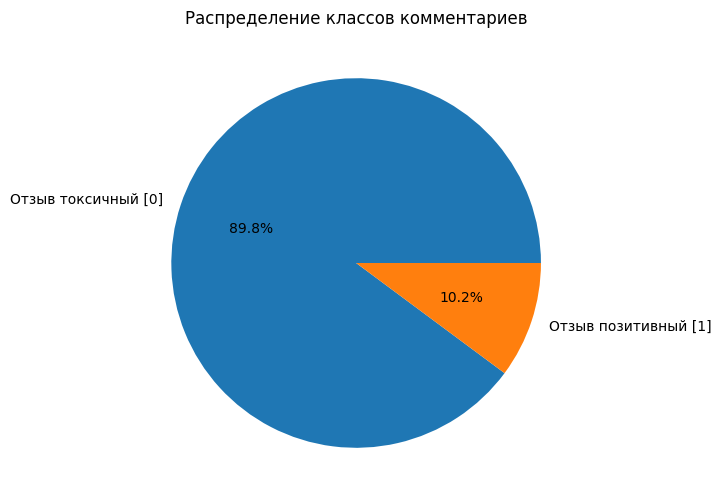

In [9]:
data['toxic'].value_counts(normalize=True).plot(kind='pie',
                                                figsize=[6,6],
                                                autopct='%1.1f%%',
                                                labels=['Отзыв токсичный [0]', 'Отзыв позитивный [1]']
                                               )

plt.title('Распределение классов комментариев')
plt.ylabel('')
plt.xlabel('')

Классы несбалансированы, для тренировочной выборки сделаем oversampling

<div class="alert alert-success">
<font size="5"><b>Комментарий ревьюера</b></font>

Успех:


Плюс за проверку на сбалансированность




<div class="alert alert-warning">

Совет:




- можно также посчитать количество слов в предложений,  длину слов в твите, опять же в разбивке по Таргету.  Если будут какие-то сильные отличия, возможно из-за этого стоит сгенерировать дополнительные признаки для наших моделей. Или например можно использовать библиотеку SentimentIntensityAnalyzer для оценки сантиментов, и посмотреть насколько хорошо ее оценки корелирует с нашими таргетами
   
   
- когда мы работаем с текстами, describe итп описательные статистике не использовать, но можно провести частотный анализ текста.  Предлагаю для этого использовать [облако слов](https://habr.com/ru/post/517410/) - чтобы получить общее представление о тематике и о наиболее часто встречаемых словах в токсичных и нетоксичных твитах (в облаке уже автоматически будут убраны стоп слова). Кроме того графики, рисунки делают проект визуально интересней
   
   
В тренажере облако импортируем так

    !pip install wordcloud


или

    !pip install wordcloud==1.8.2.2  


И возможно дополнительно надо будет сделать



    !pip install --upgrade Pillow  (попробуй версию 9.5.0)



<div class="alert alert-danger">
<font size="5"><b>Комментарий ревьюера</b></font>



Ошибка:  
    
    
- валидационный датасет должен иметь первоначальный вид (я о пропорциях нулей и единичек), раз ты ниже используешь GridSearchCV/cross_val_score он будет oversample, в итоге, на валидационной будет завышенная метрика (чтобы это исправить нужно засунуть перебалансировщик в pipeline).   Если бы всё дело ограничилось этим, еще можно было поставить желтый комментарий. Но ты и тестовую выборку oversample, тем самым полностью исказив результаты (тут простая логика - реальные данные ведь будут содержать дисбаланс, а test это имитация реального прогноза, а после балансировки он уже не отражает реальность)

<div class="alert alert-info"> <b>Комментарии студентаV1:</b> Добавил семплирование в пайплайн обучения модели, дальнейшее тестирвоание идет на изначальном датасете </div>    
    
    


<div class="alert alert-warning">
<font size="5"><b>Комментарий ревьюераV2</b></font>



Совет 🤔:


RandomOverSampler Надо было засунуть прямо в pipeline, обрати внимание на огромную разницу между метрикой на кросс валидации и тестовой, это всё результат некорректно перебалансировки.  Но по крайней мере Теперь ты не балансируешь тестовую выборку, и благодаря toxic-bert получил корректную метрику на тестовой

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
,Index: 159292 entries, 0 to 159450
,Data columns (total 2 columns):
, #   Column  Non-Null Count   Dtype 
,---  ------  --------------   ----- 
, 0   text    159292 non-null  object
, 1   toxic   159292 non-null  int64 
,dtypes: int64(1), object(1)
,memory usage: 3.6+ MB


Создадим эмбеддинги

In [11]:
torch.cuda.empty_cache()

features = generate_embeddings(data, 'text', batch_size=30)

features = features.cpu().numpy()

100%|██████████| 5310/5310 [17:10<00:00,  5.15it/s]


## Обучение

Обучим две модели классификации, после чего по результатам кросс-валидации выберем лучшую для дальнейшего тестирования

In [12]:
models = []
f1_cross = []

In [13]:
x_train, x_test, y_train, y_test = train_test_split(features,
                                                    data['toxic'],
                                                    test_size=0.5,
                                                    random_state=RANDOM_STATE)

ros = RandomOverSampler(random_state=RANDOM_STATE)

x_train_resampled, y_train_resampled = ros.fit_resample(x_train, y_train)




<div class="alert alert-warning">
<font size="5"><b>Комментарий ревьюера</b></font>




Совет:








- обрати внимание на аргумент stratify, он позволит сохранить изначальное распределение таргетов во всех новых датасетах.  Существующий дисбаланс никуда не денется, но в каждом датасете он будет одинаковым. [Почитать](https://pythonru.com/baza-znanij/sklearn-train-test-split) можно тут




### LogisticRegression

In [14]:
pipeline = Pipeline(steps=[
    ('LogisticRegression', LogisticRegression(random_state=RANDOM_STATE))
])

param_grid = {
    'LogisticRegression__C': [0.1, 1, 5],
    'LogisticRegression__solver': ['saga', 'newton-cg', 'lbfgs']
}

In [15]:
lr = RandomizedSearchCV(pipeline,
                                   param_distributions=param_grid,
                                   n_iter=5,
                                   cv=3,
                                   scoring='f1',
                                   random_state=RANDOM_STATE,
                                   n_jobs=-1)

lr.fit(x_train_resampled, y_train_resampled)

f1_lr = lr.best_score_
print("Замеряем f1 на кросс-валидации:", f1_lr)

model_lr = lr.best_estimator_

models.append(model_lr)
f1_cross.append(f1_lr)

Замеряем f1 на кросс-валидации: 0.9818603398383036


<div class="alert alert-success">
<font size="5"><b>Комментарий ревьюера</b></font>

Успех:






Корректно использован RandomizedSearchCV. Есть и другие варианты, тюнинга гиперпараметров, можешь [ознакомиться](https://www.freecodecamp.org/news/hyperparameter-optimization-techniques-machine-learning/)
  

### DecisionTreeClassifier

In [16]:
pipeline = Pipeline(steps=[
    ('DecisionTreeClassifier', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

param_grid = {
    'DecisionTreeClassifier__max_depth': [3, 5, 10],
    'DecisionTreeClassifier__min_samples_split': [2, 5, 10],
    'DecisionTreeClassifier__criterion': ['gini', 'entropy']
}

In [17]:
dtc = RandomizedSearchCV(pipeline,
                         param_distributions=param_grid,
                         cv=3,
                         scoring='f1',
                         random_state=RANDOM_STATE,
                         n_jobs=-1)

dtc.fit(x_train_resampled, y_train_resampled)

f1_dtc = dtc.best_score_
print("Замеряем f1 на кросс-валидации:", f1_dtc)

model_dtc = dtc.best_estimator_

models.append(model_dtc)
f1_cross.append(f1_dtc)

Замеряем f1 на кросс-валидации: 0.9854177932678138


### Результаты на кросс-валидации и выбор лучшей модели

In [18]:
results = []

for model, f1 in zip(models, f1_cross):

    model_name = type(model.steps[0][1]).__name__

    results.append({"Model": model_name, "f1": f1})

results_df = pd.DataFrame(results)

In [19]:
results_df

,Model,f1
0,LogisticRegression,0.981860
1,DecisionTreeClassifier,0.985418


На основании полученных результатов, DecisionTreeClassifier продемонстрировала наилучший результат по метрике F1 с значением 0.985, что делает её лидером среди рассмотренных моделей. Следующей по эффективности идёт LogisticRegression (0.981).

Таким образом, с учётом полученных результатов, мы можем с уверенностью приступить к тестированию DecisionTreeClassifier на тестовой выборке для более точной оценки её производительности.

## Тестирование

Протестируем лучшую модель кросс-валидации на тестовой выборке.

In [21]:
best_model_predictions = model_dtc.predict(x_test)

f1_model = f1_score(y_test, best_model_predictions)

print(f"f1 для DecisionTreeClassifier: {f1_model}")

f1 для DecisionTreeClassifier: 0.9052188158202668


<div class="alert alert-success">
<font size="5"><b>Комментарий ревьюера</b></font>

Успех:

- Все верно, логика моделирования не нарушена, тут тестируем только лучшую модель отобранную на валидации
    
    

<div class="alert alert-warning">



Совет:

  
- Ты получил завышенную метрику за счёт некорректной перебалансировки. Есть модели обученных на специальных в текстах и предназначенные для специальных целей, их можно поискать на  на huggingface. Там авторы указывают,на каких данных учили и для каких целей, можно поискать. В частности для нашего датосета возможно будут интересна модель  toxic-bert. Судя по названию она самое то )



    
Подгрузить можно так
    
    
    model = transformers.AutoModel.from_pretrained('unitary/toxic-bert')
    tokenizer = transformers.AutoTokenizer.from_pretrained('unitary/toxic-bert')


Предлагаю попробовать её

   
-  можно попробовать оценить важный слово с помощью библиотеки transformers-interpret
    
    
    from transformers_interpret import SequenceClassificationExplainer
    
    cls_explainer = SequenceClassificationExplainer(model, tokenizer)
    
    word_attributions = cls_explainer(Тут какой-нибудь негативный твит)
    cls_explainer.predicted_class_name
    
    
word_attributions    список кортежей, где каждый кортеж содержит токен (слово или подслово) и его важность (значение SHAP) для предсказания модели. И вот так можно пробежаться по негативным твитам,  и собрать какую-то среднюю статистику по словам которые важны для  

<div class="alert alert-warning">
<font size="5"><b>Комментарий ревьюера</b></font>

Совет:



- Как мы можем еще использовать Берт?   Можно потюнить модель Берта,  можешь взять на основу [статью (там вообще все возможные варианты рассмотрены, причём с использованием разных библиотек)](https://habr.com/ru/articles/704592/) или этот [ролик](https://www.youtube.com/watch?v=Z1J3sTJYIcc&list=PLEwK9wdS5g0qksxWxtE5c2KuFkIfUXe3i&index=14), там прямо можно посмотреть процесс кодирования, и получше разобраться в практической релизации Берта (тут реализация сложнее, метрики я видел за 0,8). Если использовать [Trainer](https://pytorch.org/rl/reference/generated/torchrl.trainers.Trainer.html), будет всё гораздо проще.
    
     

- Можно попробовать TFIDF, это устаревший подход, но зато есть возможность попрактиковаться в использовании связки pipeline+gridsearch и лемматизации (там есть свои тонкости). А в конце можно посмотреть какие слова модель считают наиболее важными



## Выводы

Вывод: по результатам исследования лучшей моделью оказалась DecisionTreeClassifier c метрикой f1 на тестовой выборке в размере 0.905, что удовлетворяет требуемому значению в 0.75

Использовалась самописная функция по извлечению эмбеддингов, которая использует предобученную модель toxic-bert. Выбор пал именно на toxic-bert из-за ограничений по памяти гп и потому, что эта модель была предобученна конкретно под эту задачу.


<div class="alert alert-info">
<font size="5"><b>Комментарий ревьюера</b></font>



Никита, у тебя старательно выполненная работа, все четко, осмысленно.




Выводы присутствуют


Логика моделирования не нарушена, RS использован корректно, здорово что использовал продвинутый подход



Так как число ошибок небольшое, можешь усложнить проект:



- можно попробовать по-другому использовать Берт/Можно использовать устаревший подход с TFIDF. плюсы в том что потренируешься в леоматизации, и использование pipeline, чтобы не было утечки данных.  Кроме того когда использую TFIDF, можно получить яркие оценки важности слов (самым важным окажется слово fuck)


- для красивой  визуализации можешь построить облако для токсичных и нетоксичных комментариев



- чтобы заглянуть внутрь модели, можешь посмотреть какой из признаков является наиболее важный для логистической регресси (должно получиться слово fuck)   




Обязательное к исправлению:




- oversampling скользкая дорожка, в частности не забываем что для  валидационного (желательно) и тестового датасета (обязательно) мы не делаем oversamping. Иначе просто искусственное завышение метрики







Жду исправлений, для принятия проекта. Если какие то вопросы, то сразу спрашивай )


<font color='green'><b>Полезные (и просто интересные) материалы:</b> \
Для работы с текстами используют и другие подходы. Например, сейчас активно используются RNN (LSTM) и трансформеры (BERT и другие с улицы Сезам, например, ELMO). НО! Они не являются панацеей, не всегда они нужны, так как и TF-IDF или Word2Vec + модели из классического ML тоже могут справляться. \
BERT тяжелый, существует много его вариаций для разных задач, есть готовые модели, есть надстройки над библиотекой transformers. Если, обучать BERT на GPU (можно в Google Colab или Kaggle), то должно быть побыстрее.\
https://huggingface.co/transformers/model_doc/bert.html \
https://t.me/renat_alimbekov \
https://colah.github.io/posts/2015-08-Understanding-LSTMs/ - Про LSTM \
https://web.stanford.edu/~jurafsky/slp3/10.pdf - про энкодер-декодер модели, этеншены\
https://pytorch.org/tutorials/beginner/transformer_tutorial.html - официальный гайд
по трансформеру от создателей pytorch\
https://transformer.huggingface.co/ - поболтать с трансформером \
Библиотеки: allennlp, fairseq, transformers, tensorflow-text — множествореализованных
методов для трансформеров методов NLP \
Word2Vec https://radimrehurek.com/gensim/models/word2vec.html


Если понравилась работа с текстами, то можешь посмотреть очень интересный (но очень-очень сложный) курс лекций: https://github.com/yandexdataschool/nlp_course .

Если нравится смотреть и слушать то есть целый курс на Ютубе https://www.youtube.com/watch?v=qDMwIQRQt-M&list=PLEwK9wdS5g0qksxWxtE5c2KuFkIfUXe3i&index=1



<div class="alert alert-info">
<font size="5"><b>Комментарий ревьюераV2</b></font>

Спасибо за работу!    

    
Красное исправлено,  но обрати внимание что из-за не совсем корректного использования перебалансировки ты получаешь  завышенную метрику на кросс валидации

 
  
А в остальном работа Никита. Желаю успехов в дальнейшей учебе!
 

</div>

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Модели обучены
- [x]  Значение метрики *F1* не меньше 0.75
- [x]  Выводы написаны